In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

df_batters = pd.read_csv('~/Desktop/Springboard/CapstoneThree/data/final/batters.csv')
df_batters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   player_id       1477 non-null   object 
 1   g_y             1477 non-null   float64
 2   ab              1477 non-null   float64
 3   r_y             1477 non-null   float64
 4   h_y             1477 non-null   float64
 5   double          1477 non-null   float64
 6   triple          1477 non-null   float64
 7   hr_y            1477 non-null   float64
 8   rbi             1477 non-null   float64
 9   sb              1477 non-null   float64
 10  bb_y            1477 non-null   float64
 11  so_y            1477 non-null   float64
 12  hbp_y           1477 non-null   float64
 13  sh_y            1477 non-null   float64
 14  weight          1477 non-null   float64
 15  height          1477 non-null   float64
 16  HoF_nomination  1477 non-null   float64
dtypes: float64(16), object(1)
memory 

In [2]:
y = df_batters['HoF_nomination']
X = df_batters.drop(['player_id','HoF_nomination'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_x = MinMaxScaler((-1,1))
X_train[['g_y', 'ab', 'r_y', 'h_y', 'double', 'triple', 'hr_y', 'rbi', 'sb', 'bb_y', 'so_y', 'hbp_y', 'sh_y', 'weight', 'height']] = scaler_x.fit_transform(X_train[['g_y', 'ab', 'r_y', 'h_y', 'double', 'triple', 'hr_y', 'rbi', 'sb', 'bb_y', 'so_y', 'hbp_y', 'sh_y', 'weight', 'height']])
X_test[['g_y', 'ab', 'r_y', 'h_y', 'double', 'triple', 'hr_y', 'rbi', 'sb', 'bb_y', 'so_y', 'hbp_y', 'sh_y', 'weight', 'height']] = scaler_x.transform(X_test[['g_y', 'ab', 'r_y', 'h_y', 'double', 'triple', 'hr_y', 'rbi', 'sb', 'bb_y', 'so_y', 'hbp_y', 'sh_y', 'weight', 'height']])

We want to predict whether or not each player will receive a Hall of Fame nomination. Therefore, this is a classification problem and we will try four different kinds of classification models: Logistic Regression, Support Vector Machine (SVM), Random Forest, and Gradient Boosted Trees 

**Logistic Regression**

In [3]:
from sklearn.linear_model import LogisticRegression

C_param_range = [0.001,0.01,0.1,1,10,100]

table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
table['C_parameter'] = C_param_range


j = 0
for i in C_param_range:
    
    Logreg = LogisticRegression(C = i,random_state = 42)
    Logreg.fit(X_train,y_train)
    y_pred_lr = Logreg.predict(X_test)
    
    table.iloc[j,1] = accuracy_score(y_test,y_pred_lr)
    j += 1
    
table

,C_parameter,Accuracy
0,0.001,0.685811
1,0.010,0.797297
2,0.100,0.804054
3,1.000,0.810811
4,10.000,0.793919
5,100.000,0.787162


Choose C (inverse of regularization strength) that optimizes accuracy, and create confusion matrix/accuracy score

In [4]:
Logreg = LogisticRegression(C = 1,random_state = 42)
Logreg.fit(X_train,y_train)
y_pred_lr = Logreg.predict(X_test)

cnf_matrix= confusion_matrix(y_test,y_pred_lr)
print(cnf_matrix)
Accuracy_lr=Logreg.score(X_test,y_test)

print(Accuracy_lr)

[[172  25]
 [ 31  68]]
0.8108108108108109


Use cross validation to determine ROC_AUC score for training and testing data

In [5]:
cv_scores_test= cross_val_score(Logreg,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(Logreg,X_train,y_train,cv=5,scoring='roc_auc')

cv_scores_lr_test= cv_scores_test.mean()
cv_scores_lr_train= cv_scores_train.mean()

print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))

Mean cross validation test score: 0.8149018218623482
Mean cross validation train score: 0.8371485611956165


**Support Vector Machine**

In [6]:
from sklearn.svm import SVC

svm = SVC(random_state=42)
svm.fit(X_train, y_train)

y_predict_svm=svm.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_predict_svm)
print(cnf_matrix)

[[176  21]
 [ 38  61]]


SVM Hyperparameter Tuning:

In [7]:
svm = SVC(random_state=42)

param_grid = { "C" : [0.1, 1, 10, 100, 1000], "gamma": [1, 0.1, 0.01, 0.001, 0.0001], "kernel": ['linear', 'poly', 'rbf', 'sigmoid']}

gs = GridSearchCV(estimator=svm, param_grid=param_grid, scoring='roc_auc', n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_estimator_) 
print(gs.best_score_)

SVC(C=1000, gamma=0.001, kernel='sigmoid', random_state=42)
0.8359986531498477


Fit model with optimized hyperparameters

In [8]:
svm = SVC(C=1000, gamma=0.001, kernel='sigmoid', random_state=42)
svm.fit(X_train, y_train)

SVC(C=1000, gamma=0.001, kernel='sigmoid', random_state=42)

Use cross validation to determine ROC_AUC score for training and testing data

In [9]:
cv_scores_test= cross_val_score(svm,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(svm,X_train,y_train,cv=5,scoring='roc_auc')

cv_scores_svm_test= cv_scores_test.mean()
cv_scores_svm_train= cv_scores_train.mean()

print ('Mean cross validation test score: ' +str(cv_scores_svm_test))
print ('Mean cross validation train score: ' +str(cv_scores_svm_train))

Accuracy_svm=svm.score(X_test,y_test)
print(Accuracy_svm)

Mean cross validation test score: 0.8055647773279352
Mean cross validation train score: 0.8359986531498477
0.8040540540540541


**Random Forest**

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_predict_rf = rf.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_predict_rf)
print(cnf_matrix)

[[173  24]
 [ 33  66]]


RF Hyperparameter Tuning:

In [11]:
rf = RandomForestClassifier(random_state=42)

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2, 4, 10,12,16], "n_estimators": [50, 100,400,700,1000]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

gs = gs.fit(X_train, y_train)

print(gs.best_estimator_) 
print(gs.best_score_)

RandomForestClassifier(min_samples_leaf=5, min_samples_split=16,
                       n_estimators=400, random_state=42)
0.829076229906717


Fit model with optimized hyperparameters

In [12]:
rf = RandomForestClassifier(min_samples_leaf=5, min_samples_split=16,
                       n_estimators=400)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=5, min_samples_split=16,
                       n_estimators=400)

Use cross validation to determine ROC_AUC score for training and testing data

In [13]:
cv_scores_test= cross_val_score(rf,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(rf,X_train,y_train,cv=5,scoring='roc_auc')

cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train= cv_scores_train.mean()

print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))

Accuracy_rf=rf.score(X_test,y_test)
print(Accuracy_rf)

Mean cross validation test score: 0.8162661943319838
Mean cross validation train score: 0.8259497196075412
0.7972972972972973


   Features  Importance scores
0       g_y           0.013360
1        ab           0.021225
2       r_y           0.027530
3       h_y           0.031745
4    double           0.037604
5    triple           0.037706
6      hr_y           0.041348
7       rbi           0.055880
8        sb           0.064387
9      bb_y           0.074219
10     so_y           0.090102
11    hbp_y           0.115519
12     sh_y           0.126610
13   weight           0.128961
14   height           0.133802


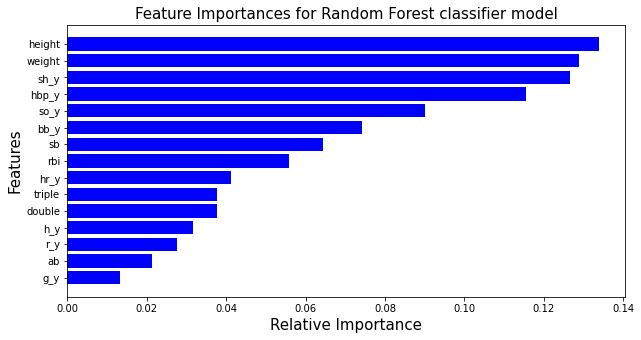

In [14]:
features = X
importances = list(rf.feature_importances_)
imp=np.sort(importances)
tab=pd.DataFrame(list(zip(X,imp)),columns =['Features', 'Importance scores']) 
print(tab)

plt.figure(figsize=(10,5))
indices = np.argsort(importances)
index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
_=plt.barh(index,imp, align='center',color='b')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.yticks(index, features)
plt.title('Feature Importances for Random Forest classifier model',fontsize=15)
plt.show()

**Gradient Boosting**

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

y_predict_gbc = gbc.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_predict_gbc)
print(cnf_matrix)

[[173  24]
 [ 38  61]]


GB Hyperparameter Tuning:

In [16]:
gbc = GradientBoostingClassifier(random_state=42)
gb_param = {
        'loss' : ["deviance"],
        'n_estimators' : [100,200,300],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [4, 8],
        'min_samples_leaf': [100,150],
        'max_features': [0.3, 0.1] 
        }

gsgbc = GridSearchCV(gbc, param_grid = gb_param, cv=5, scoring="roc_auc", n_jobs= -1, verbose = 1)
gsgbc.fit(X_train,y_train)
print(gsgbc.best_estimator_)
print(gsgbc.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.9s


GradientBoostingClassifier(learning_rate=0.05, max_depth=8, max_features=0.1,
                           min_samples_leaf=150, random_state=42)
0.8276999936583289


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   33.4s finished


Fit model with optimized hyperparameters

In [17]:
gbc = GradientBoostingClassifier(learning_rate=0.05, max_depth=8, max_features=0.1,
                           min_samples_leaf=150)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=8, max_features=0.1,
                           min_samples_leaf=150)

Use cross validation to determine ROC_AUC score for training and testing data

In [18]:
cv_scores_test= cross_val_score(gbc,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(gbc,X_train,y_train,cv=5,scoring='roc_auc')

cv_scores_gbc_test= cv_scores_test.mean()
cv_scores_gbc_train= cv_scores_train.mean()

print ('Mean cross validation test score: ' +str(cv_scores_gbc_test))
print ('Mean cross validation train score: ' +str(cv_scores_gbc_train))

Accuracy_gbc=gbc.score(X_test,y_test)
print(Accuracy_gbc)

Mean cross validation test score: 0.5
Mean cross validation train score: 0.8232126271731548
0.8040540540540541


   Features  Importance scores
0       g_y           0.005460
1        ab           0.013174
2       r_y           0.018639
3       h_y           0.022189
4    double           0.033574
5    triple           0.055207
6      hr_y           0.059843
7       rbi           0.062175
8        sb           0.067825
9      bb_y           0.077707
10     so_y           0.086882
11    hbp_y           0.105683
12     sh_y           0.126408
13   weight           0.127170
14   height           0.138064


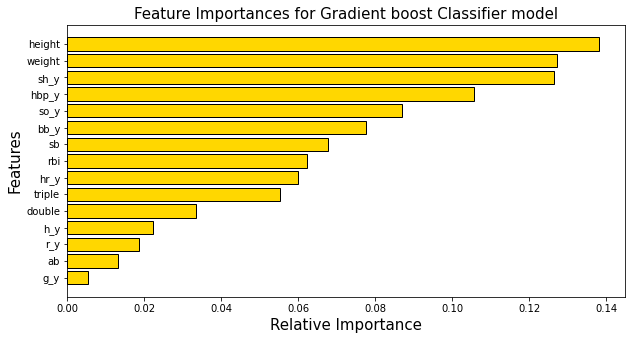

In [19]:
features = X
importances = list(gbc.feature_importances_)
imp=np.sort(importances)
tab=pd.DataFrame(list(zip(X,imp)),columns =['Features', 'Importance scores']) 
print(tab)

plt.figure(figsize=(10,5))
indices = np.argsort(importances)
index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
_=plt.barh(index,imp, align='center',color='gold',edgecolor='k')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.yticks(index, features)
plt.title('Feature Importances for Gradient boost Classifier model',fontsize=15)
plt.show()

**Model Comparison**

In [20]:
myLabels = [ 'Logistic Regression','SVM','Random Forest','Gradient Boost']
score_test= [  cv_scores_lr_test,cv_scores_svm_test,cv_scores_rf_test,cv_scores_gbc_test]
score_train= [  cv_scores_lr_train,cv_scores_svm_train,cv_scores_rf_train,cv_scores_gbc_train]
Accuracy_score = [Accuracy_lr,Accuracy_svm,Accuracy_rf,Accuracy_gbc]

score_tab_acc = pd.DataFrame(list(zip(myLabels, Accuracy_score)), 
               columns =['Algorithm', 'Model accuracy score']) 

score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
               columns =['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score' ]) 
print(score_tab_acc)

score_tab

             Algorithm  Model accuracy score
0  Logistic Regression              0.810811
1                  SVM              0.804054
2        Random Forest              0.797297
3       Gradient Boost              0.804054


,Algorithm,ROC-AUC train score,ROC-AUC test score
0,Logistic Regression,0.837149,0.814902
1,SVM,0.835999,0.805565
2,Random Forest,0.825950,0.816266
3,Gradient Boost,0.823213,0.500000


Read in ineligible batters dataframe

In [21]:
df_ineligible_batters = pd.read_csv('~/Desktop/Springboard/CapstoneThree/data/final/ineligible_batters.csv')

Use our logistic regression model to predict which players will receive a nomination in the future

In [22]:
X = df_ineligible_batters.drop(['player_id','HoF_nomination'], axis=1)
X[['g_y', 'ab', 'r_y', 'h_y', 'double', 'triple', 'hr_y', 'rbi', 'sb', 'bb_y', 'so_y', 'hbp_y', 'sh_y', 'weight', 'height']] = scaler_x.fit_transform(X[['g_y', 'ab', 'r_y', 'h_y', 'double', 'triple', 'hr_y', 'rbi', 'sb', 'bb_y', 'so_y', 'hbp_y', 'sh_y', 'weight', 'height']])

ineligible_batter_HoF_prediction=Logreg.predict(X)

Concatenate nomination predictions with player_id, then merge these with the names of the players that correspond with each player_id

In [23]:
HoF_Predictions = pd.concat([df_ineligible_batters['player_id'], pd.Series(ineligible_batter_HoF_prediction)],axis=1).set_index('player_id')

In [24]:
df_players = pd.read_csv('~/Desktop/Springboard/CapstoneThree/data/raw/player.csv')
names = df_players[['player_id','name_first','name_last']]

df_predictions = pd.merge(left=HoF_Predictions, right=names, on='player_id')
df_predictions.rename(columns={ df_predictions.columns[1]: "nomination" }, inplace = True)

Print entire dataframe, starting with the players that are predicted to be nominated to HoF

In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_predictions.sort_values(by='nomination', ascending=False))

     player_id  nomination name_first    name_last
0    abreubo01         1.0      Bobby        Abreu
136  molinya01         1.0     Yadier       Molina
123  loneyja01         1.0      James        Loney
126  markani01         1.0       Nick     Markakis
127  martiru01         1.0    Russell       Martin
128  martivi01         1.0     Victor     Martinez
129  matsuhi01         1.0     Hideki       Matsui
130  mauerjo01         1.0        Joe        Mauer
131  mccanbr01         1.0      Brian       McCann
137  montemi01         1.0     Miguel      Montero
158  peraljh01         1.0     Jhonny      Peralta
138  moralke01         1.0    Kendrys      Morales
139   morame01         1.0     Melvin         Mora
140  morneju01         1.0     Justin      Morneau
144  napolmi01         1.0       Mike       Napoli
150  ordonma01         1.0    Magglio      Ordonez
151  ortizda01         1.0      David        Ortiz
154  pedrodu01         1.0     Dustin      Pedroia
122   lindad01         1.0     